In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [14]:
# Configurations
experiment_dir = './'
num_iterations = 30000

# Start and end indices are shifted right
# col_idx_start = 400
# col_idx_end = 415

In [15]:
# Load the sine wave samples from the CSV file
gt_signal_path = os.path.join(experiment_dir, 'gt_signal.csv')
df = pd.read_csv(gt_signal_path, index_col='period')
print("Shape before flattening:", df.shape)
window_size = df.shape[1]
original_signal = df.values.flatten()

Shape before flattening: (20, 15)


In [16]:
gt_images_dir = os.path.join(experiment_dir, f'test/ours_{num_iterations}/gt')
render_images_dir = os.path.join(experiment_dir, f'test/ours_{num_iterations}/renders')


# Get a list of all .png files in the directory and sort them by filename
gt_image_files = sorted([f for f in os.listdir(gt_images_dir) if f.endswith('.png')])
render_image_files = sorted([f for f in os.listdir(render_images_dir) if f.endswith('.png')])

# Initialize an empty list to store the images
gt_images = []
render_images = []

# Read and store the images in the list
for image_file in gt_image_files:
    image_path = os.path.join(gt_images_dir, image_file)
    with Image.open(image_path) as img:
        gt_images.append(np.array(img))

for image_file in render_image_files:
    image_path = os.path.join(render_images_dir, image_file)
    with Image.open(image_path) as img:
        render_images.append(np.array(img))

# Convert the list to a numpy array for further processing if needed
gt_images_array = np.array(gt_images)
render_images_array = np.array(render_images)

# Display the shape of the array to confirm the images are stored correctly
print("Number of iterations:", num_iterations)
print("GT Images shape:", gt_images_array.shape)
print("Render Images shape:", render_images_array.shape)

Number of iterations: 30000
GT Images shape: (20, 800, 800, 3)
Render Images shape: (20, 800, 800, 3)


In [17]:
# Compute the horizontal region of interest (center of the image)
row_idx = render_images[0].shape[0] // 2
col_idx_mid = render_images[0].shape[1] // 2
col_idx_start = col_idx_mid - window_size // 2
col_idx_end = col_idx_mid + window_size // 2
if window_size % 2 != 0:
    col_idx_end += 1

col_idx_start = 400
col_idx_end = 415

print(f"Region of interest is: [{row_idx}, {col_idx_start}:{col_idx_end}], yielding a window size of {col_idx_end-col_idx_start} pixels.")

Region of interest is: [400, 400:415], yielding a window size of 15 pixels.


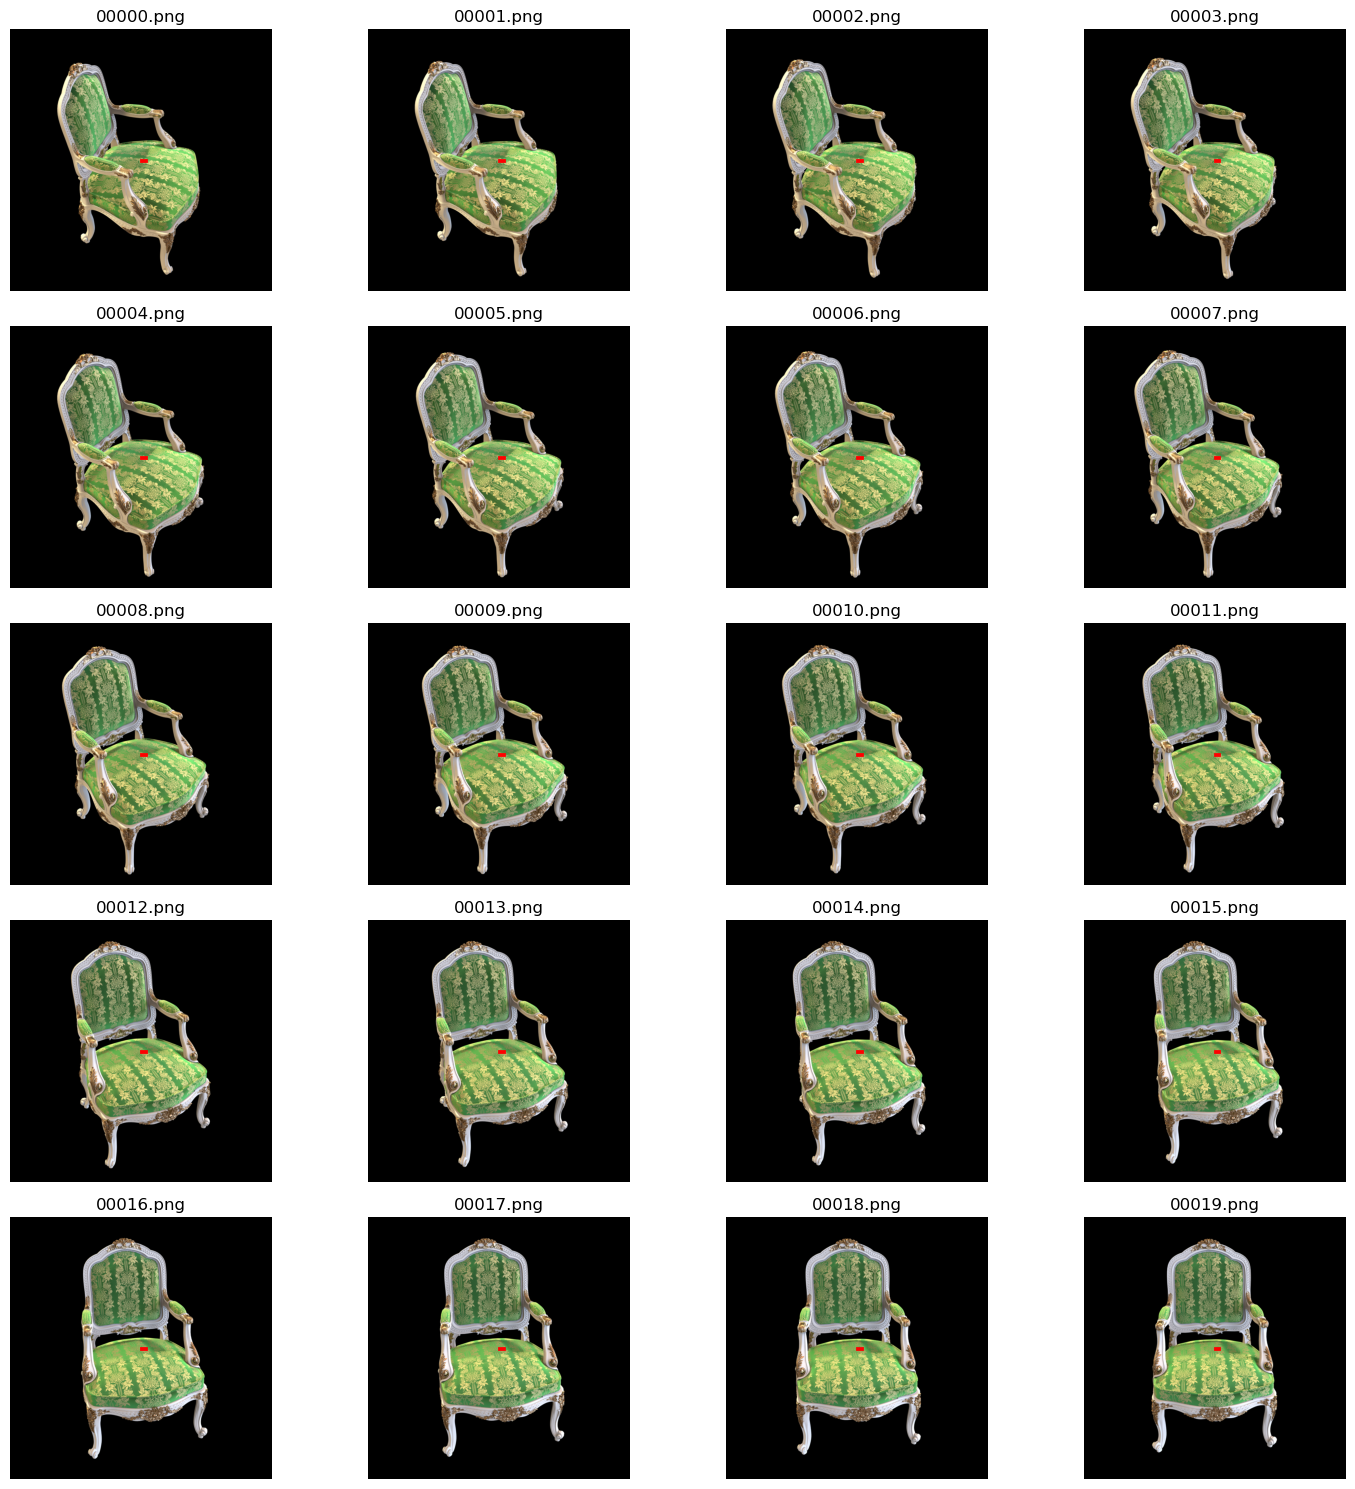

In [18]:
# Plot all the ground-truth images as subfigures with the region of interest highlighted
num_images = len(gt_images)
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows in the subplot grid

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

for i, img in enumerate(gt_images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide the axis
    axs[i].set_title(gt_image_files[i])  # Display the filename as the title

    rect = patches.Rectangle(
        (col_idx_start, row_idx), 
        col_idx_end - col_idx_start, 
        1,  # Height of 1 to cover the row
        linewidth=2, 
        edgecolor='r', 
        facecolor='none'
    )

    # Add the patch to the Axes
    axs[i].add_patch(rect)

# Hide any unused subplots
for i in range(num_images, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

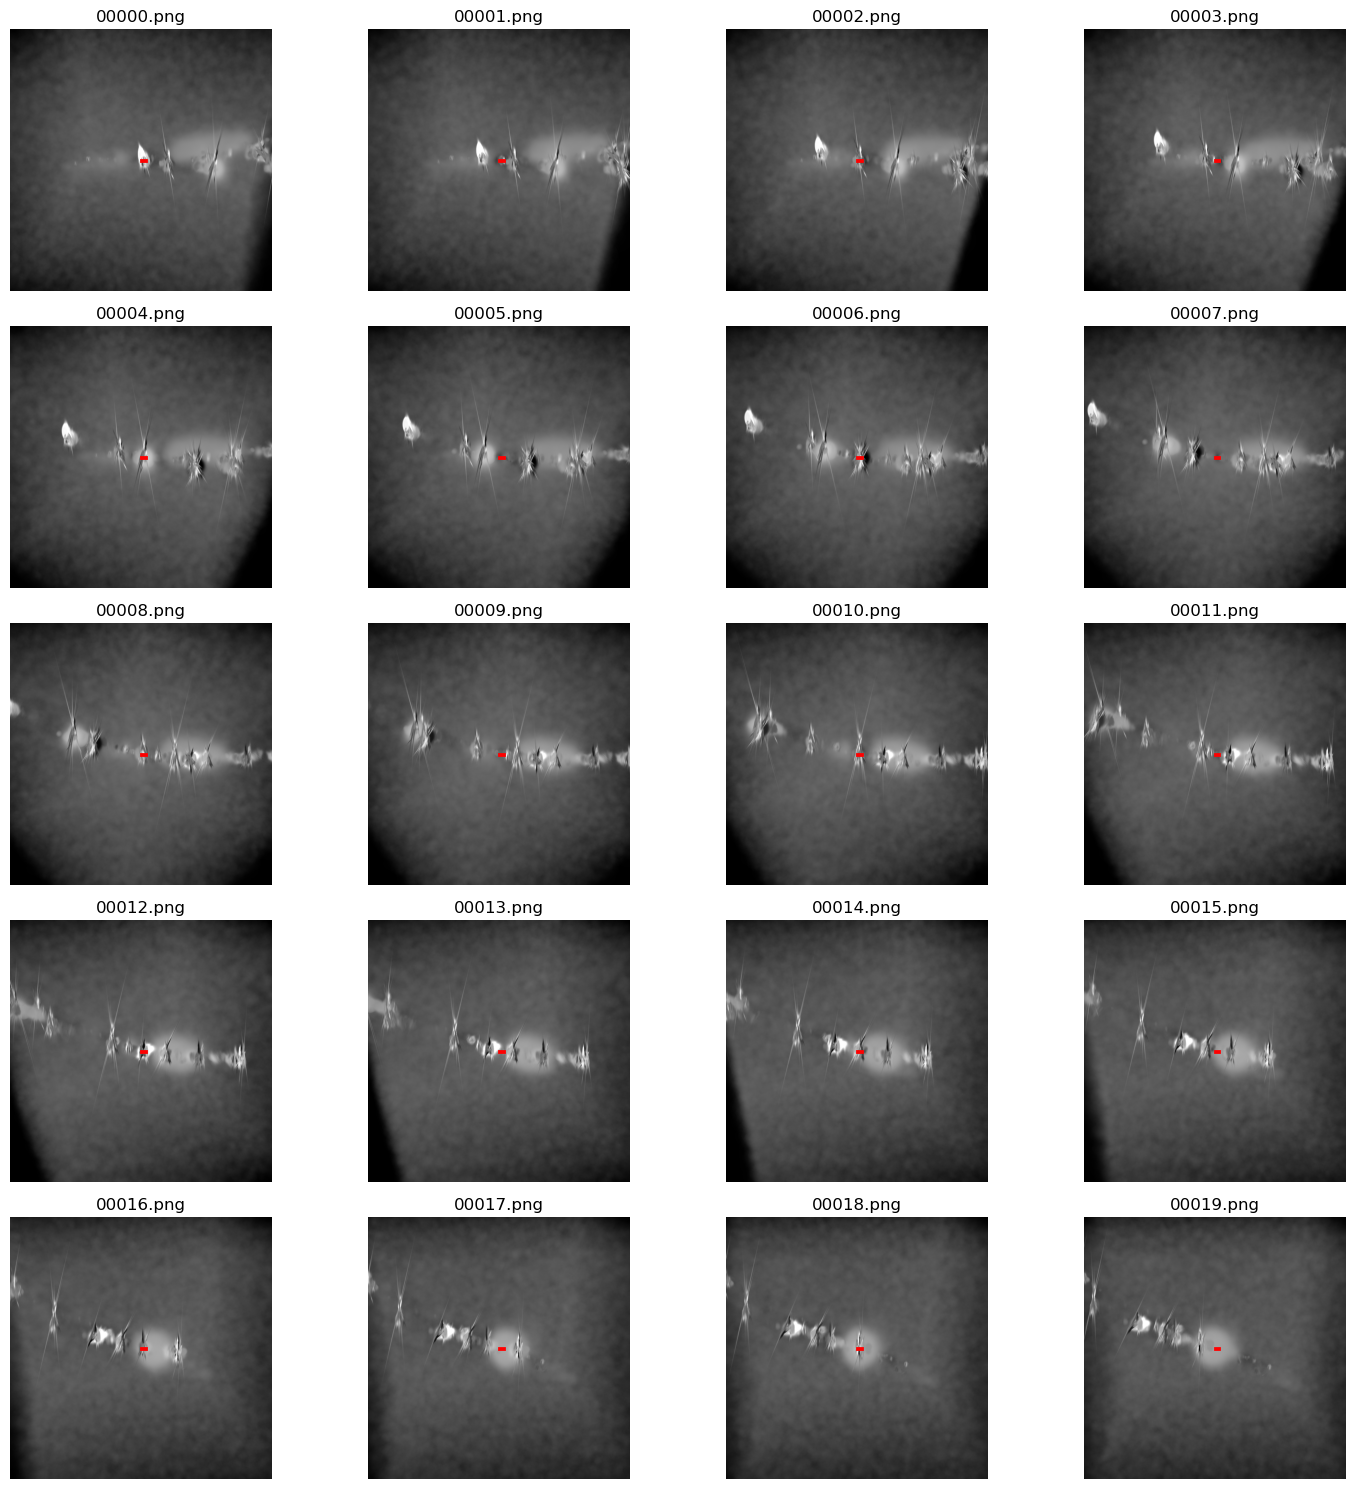

In [19]:
# Plot all the rendered images as subfigures with the region of interest highlighted
num_images = len(render_images)
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows in the subplot grid

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

for i, img in enumerate(render_images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide the axis
    axs[i].set_title(render_image_files[i])  # Display the filename as the title

    rect = patches.Rectangle(
        (col_idx_start, row_idx), 
        col_idx_end - col_idx_start, 
        1,  # Height of 1 to cover the row
        linewidth=2, 
        edgecolor='r', 
        facecolor='none'
    )

    # Add the patch to the Axes
    axs[i].add_patch(rect)

# Hide any unused subplots
for i in range(num_images, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [20]:
signal_window = render_images_array[:, row_idx, col_idx_start:col_idx_end, :]
print("signal windows shape - RGB:", signal_window.shape)

# Convert RGB to grayscale
signal_window_gray = np.dot(signal_window, [0.2989, 0.5870, 0.1140])
print("signal windows shape - GS:", signal_window_gray.shape)


signal windows shape - RGB: (20, 15, 3)
signal windows shape - GS: (20, 15)


In [21]:
pred_signal = signal_window_gray.flatten()
print("Shape:", pred_signal.shape)
print("Min:", pred_signal.min(), "Max", pred_signal.max())


Shape: (300,)
Min: 0.0 Max 248.9751


In [22]:
# Normalise predicted signal
pred_signal_norm = (pred_signal - pred_signal.min()) / (pred_signal.max() - pred_signal.min())
print("Min:", pred_signal_norm.min(), "Max", pred_signal_norm.max())

Min: 0.0 Max 1.0


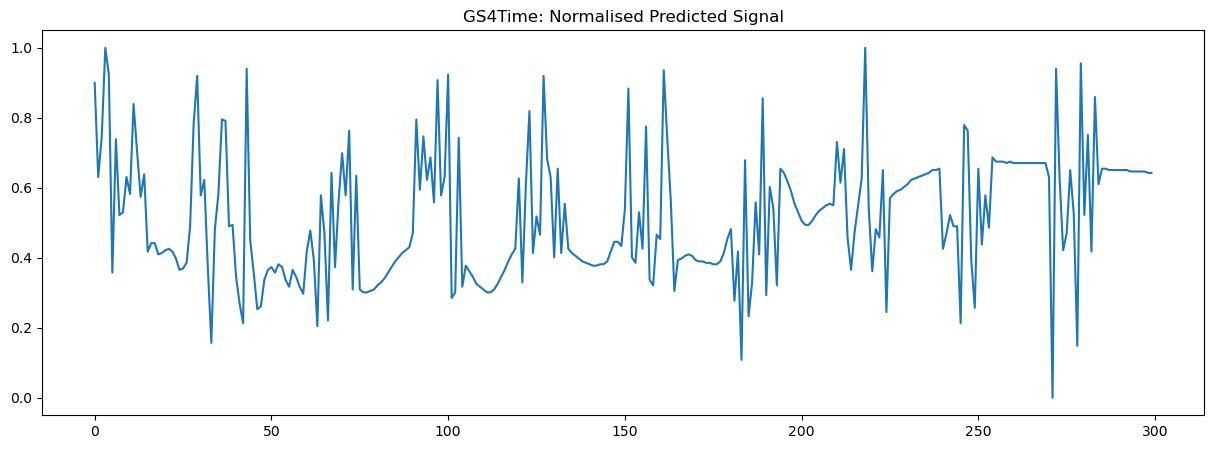

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(pred_signal_norm)
plt.title("GS4Time: Normalised Predicted Signal")
plt.show()

L1 Loss: 0.1029
MSE: 0.0305


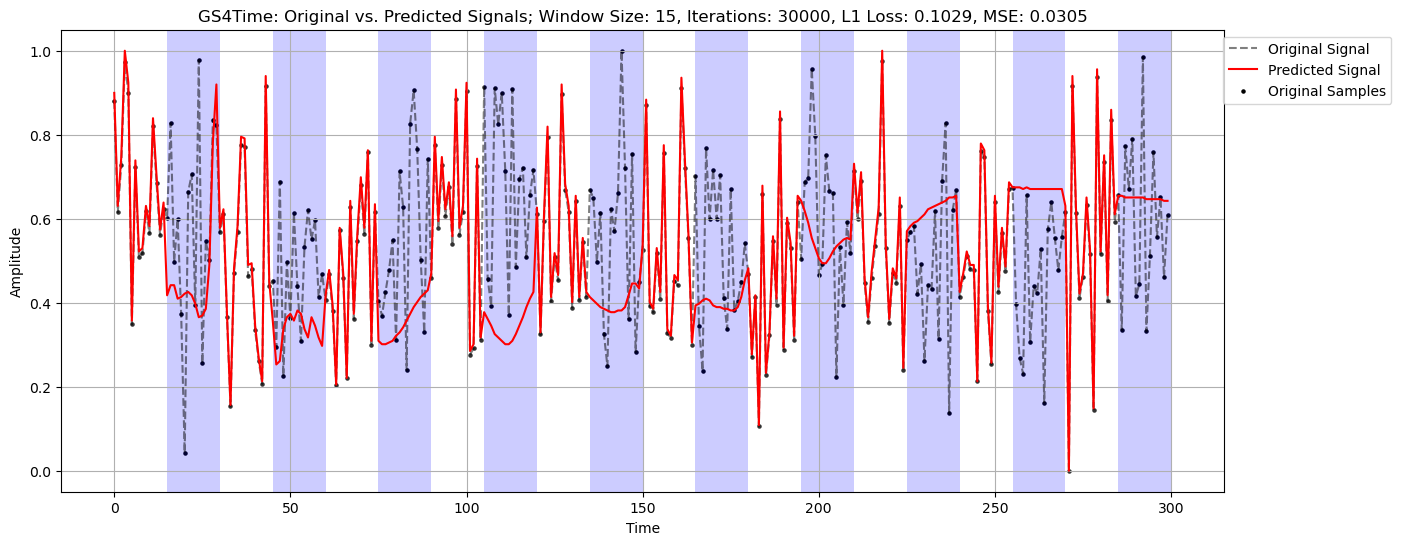

In [24]:
time_index = np.arange(len(original_signal))
window_size = df.shape[1]

plt.figure(figsize=(15, 6))
# Plot the entire signal
plt.plot(time_index, original_signal, color='black', label='Original Signal', linestyle='dashed', alpha=0.5)
plt.plot(time_index, pred_signal_norm, color='red', label='Predicted Signal')
plt.scatter(time_index, original_signal, color='black', s=5, label='Original Samples')

# Shade the background for each window
# WHITE: train region, 
# BLUE: test region
background_colors = ['white', 'blue']
for i in range(df.shape[0]):
    start_idx = i * window_size
    end_idx = (i + 1) * window_size
    plt.axvspan(start_idx, end_idx, facecolor=background_colors[i % len(background_colors)], alpha=0.2)

# Compute Performance Metrics
l1_loss = np.abs(original_signal - pred_signal_norm).mean()
print(f'L1 Loss: {l1_loss:.4f}')

mse = ((original_signal - pred_signal_norm) ** 2).mean()
print(f'MSE: {mse:.4f}')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'GS4Time: Original vs. Predicted Signals; Window Size: {window_size}, Iterations: {num_iterations}, L1 Loss: {l1_loss:.4f}, MSE: {mse:.4f}')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()
